In [0]:
import os
import torch
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
import timeit
import random
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn import preprocessing
from skimage.transform import rescale, resize, downscale_local_mean
height = int(480/2)
width = int(640/2)

'''Creates Random tensor that is the same size as the image (for testing)'''
def imageBatch(nb_image):
    imgBatch = torch.rand(nb_image, 3, width, height)
    return imgBatch

'''Creates Random tensor that is the same size as the depthmap (for testing)'''
def depthBatch(nb_image):
    depthBatch = torch.rand(nb_image, width*height, 1, 1)
    return depthBatch

def normalize(imageBatch):
    for i in range(len(imageBatch)):
      imageBatch[i] = preprocessing.normalize(imageBatch[i], norm='l2', axis=1, copy=True, return_norm=False)
    return imageBatch

'''CNN doing the first stage of the Semi-Siamese Network (forms the two 'heads')'''
def firstStageCNN():
    return nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2),  # optional: add stride
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),

                         nn.Conv2d(32, 62, kernel_size=3, stride=2),
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),
                         nn.MaxPool2d(kernel_size=3),  # optional: add stride
                         nn.ReLU(inplace=True),

                         nn.Conv2d(62, 92, kernel_size=3, stride=2),  # optional: add stride
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),

                         nn.MaxPool2d(kernel_size=3),  # optional: add stride
                         nn.ReLU(inplace=True))

'''Form the complete network by taking the two heads and connecting them to
the body'''
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = firstStageCNN()

        self.cnn2 = firstStageCNN()

        self.fc = nn.Sequential(nn.Conv2d(2208, 92, kernel_size=1),
                                nn.ReLU(inplace=True),

                                nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(92, 62, kernel_size=1),
                                nn.ReLU(inplace=True),

                                nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(62, 32, kernel_size=4),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(32, width*height, kernel_size=1),
                                nn.ReLU(inplace=True),
                                nn.Softmax2d()
                                )

    '''forwards through the first CNNs to the Main body then returns the output'''
    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output2 = self.cnn2(input2)

        combined = torch.cat((output1.view(output1.size(0), -1),
                              output2.view(output2.size(0), -1)), dim=1)

        combined = torch.unsqueeze(combined, 2)
        combined = torch.unsqueeze(combined, 3)
        out = self.fc(combined)
        return out

''' Does the training of the whole dataset'''
def train(net, training_DATA_LEFT, training_DATA_RIGHT, depthMaps, EPOCHS, BATCH_SIZE):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_function = nn.BCELoss()
    dataset = utils.TensorDataset(training_DATA_LEFT, training_DATA_RIGHT, depthMaps)
    train_dataloader = DataLoader(dataset, shuffle=True, num_workers=0, batch_size=1)
    net.zero_grad()
    COUNTER = 1
    avg_loss = []
    print("train function was executed")
    for epoch in range(EPOCHS):
        for i, data in enumerate(train_dataloader):

            img1, img2, depthmap = data
            optimizer.zero_grad() # reset gradient
            outputs = net(img1, img2)
            loss = loss_function(outputs, depthmap)
            print("Loss:", loss)
            avg_loss.append(loss.detach())

            loss.backward()
            optimizer.step()
        #Print out images and epoch numbers 
        print("Epoch number: ", COUNTER)
        COUNTER += 1 
        avg_loss = np.array(avg_loss)
        print("Average Loss:", np.mean(avg_loss))
        avg_loss = []
        plt.figure()
        plt.imshow((outputs.view(height,width)).detach().numpy())
        # plt.show()
        plt.figure()
        plt.imshow((depthmap.view(height,width)).detach().numpy())
        # plt.show
        image = img1.view(3,height,width)
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(image.detach().numpy(),0,2),0,1))
        plt.show()
        outputs = net(img1, img2)
        img1 = img1.view(3,height,width)
        plt.figure()
        plt.imshow((outputs.view(height,width)).detach().numpy())
        plt.figure()
        plt.imshow((depthmap.view(height,width)).detach().numpy())
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(img1.detach().numpy(),0,2),0,1))
        plt.show()
    return net
def rescale_img(imageL, imageR, depthMap):
  resizedL = []
  resizedR = []
  resizedDepth = []
  for img in imageL:
    resizedL.append(rescale(img, (1,0.5,0.5), anti_aliasing=True))
  for img in imageR:
    resizedR.append(rescale(img, (1,0.5,0.5), anti_aliasing=True))
  for img in depthMap:
    resizedDepth.append(rescale(img, 0.5, anti_aliasing=True))
  return np.array(resizedL), np.array(resizedR), np.array(resizedDepth)


train function was executed
Loss: tensor(3616.0208, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(1970.3512, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2998.0762, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4082.5093, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4492.4565, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4520.9766, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2213.6042, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3242.1501, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(1868.5885, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2744.4470, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2766.9426, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2157.6812, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2479.7866, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(5421.9663, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4752.2515, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3320.3340, grad_fn=<BinaryCro

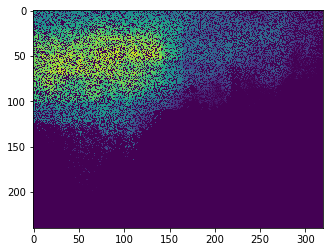

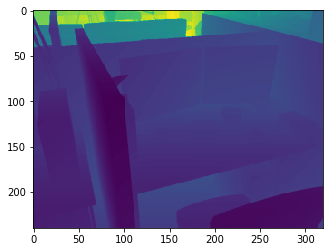

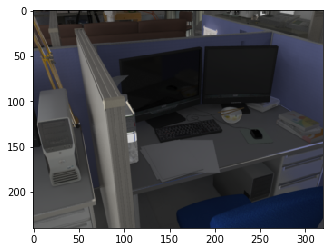

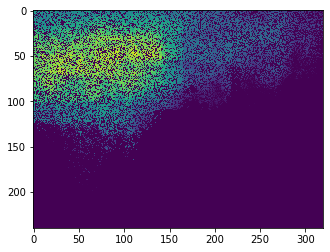

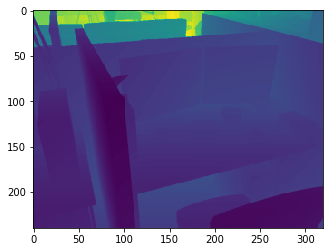

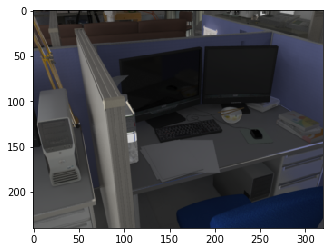

Loss: tensor(4615.7500, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3523.2754, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2743.6172, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3574.0447, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(5429.7925, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2190.9639, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2277.1672, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(5065.7202, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2771.8599, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2690.0664, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3017.4004, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4240.7661, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3308.4780, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4080.2153, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4073.3103, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3002.8213, grad_fn=<BinaryCrossEntropyBackward>)
Loss: te

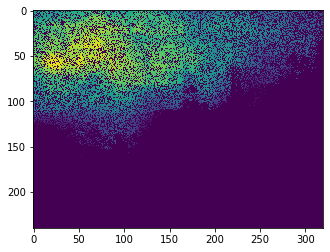

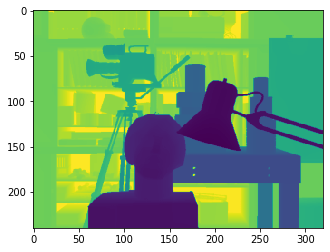

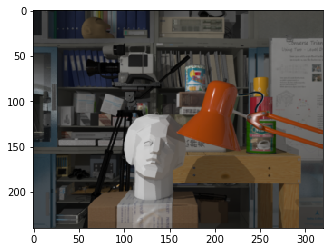

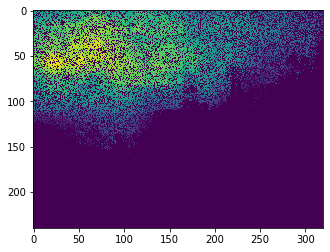

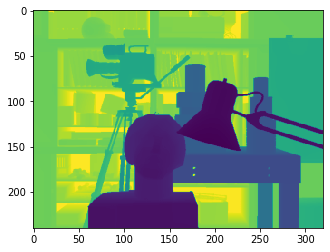

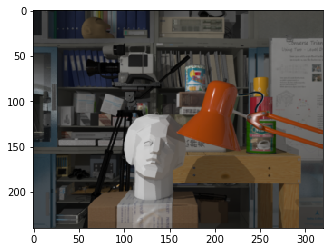

Loss: tensor(2818.0310, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2053.4924, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2711.1057, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4166.9360, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2532.0010, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(1490.6635, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(1904.6350, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3518.5818, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(5253.6177, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3011.2107, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3126.3142, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(1744.1971, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4840.8887, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(2015.6748, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(4929.0474, grad_fn=<BinaryCrossEntropyBackward>)
Loss: tensor(3031.5276, grad_fn=<BinaryCrossEntropyBackward>)
Loss: te

KeyboardInterrupt: ignored

In [110]:
def main():
    height = 240
    width = 320
    net = SiameseNetwork()
    #This will import the real dataset in tensor arrays once the data is available
    training_DATA_LEFT = np.load('test_daylight_left.npy')
    training_DATA_RIGHT = np.load('test_daylight_right.npy')
    depthMaps = np.load('test_depthmap_left.npy')
    training_DATA_LEFT, training_DATA_RIGHT, depthMaps = rescale_img(training_DATA_LEFT, training_DATA_RIGHT, depthMaps)
    # depthMaps = normalize(depthMaps)
    # training_DATA_LEFT = np.swapaxes(training_DATA_LEFT,1,3)
    # training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,3)
    training_DATA_LEFT = torch.from_numpy(training_DATA_LEFT)
    training_DATA_RIGHT = torch.from_numpy(training_DATA_RIGHT)
    depthMaps = torch.from_numpy(depthMaps)
    # reshape output
    depthMaps = depthMaps.view(-1,int(width*height),1,1)
    network = final = train(net, training_DATA_LEFT, training_DATA_RIGHT, depthMaps, EPOCHS = 15, BATCH_SIZE = 5)
    torch.save(network, 'saved_network')

if __name__ == '__main__':
    main()

In [7]:
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!ls "/content/drive/My Drive"

 0073402699_Principles.pdf
'Academic advising'
 Adulo
'Alas Herro.pdf'
"Article: Fed's Harker says trade helps many, but those it hurts are hit hard"
'Article: Nobel laureate Maskin wants bureaucrats to set euro fiscal policy'
'Article: Oil prices down on profit-taking after two-day jump'
'Article: Peru to boost liquidity of sol debt after global bond sale: finance minister'
'Article: Sharp says to invest 57.4 billion yen in OLED business'
'Article: The divided party system is posing a big threat to the stock market'
'Article: Vietnam’s Economy Expands 6.4% in Third Quarter on Export Boom'
'Article: Yen, Swiss franc near one-month high vs dollar as risk sentiment sours'
'attachment (1).ashx'
 attachment.ashx
'Colab Notebooks'
'Darwin Ortiz - Strong Magic.pdf'
 depthmaps_numpy.npy
'Dody Moving.vcf'
'Drone vids'
 Ereader.zip
'Fenora '
'flyer 2.pdf'
 flyer.pdf
 flyer.pptx
'Godfrey-Smith Chapter 15.pdf'
 group2_SpeechToSongIllusion_ZbigniewSzymonFonau.pptx
 Guide
'Heat Shock Proteins.gslid

In [0]:
!cp "/content/drive/My Drive/Sample test data/test_daylight_left.npy" "test_daylight_left.npy"
!cp "/content/drive/My Drive/Sample test data/test_daylight_right.npy" "test_daylight_right.npy"
!cp "/content/drive/My Drive/Sample test data/test_depthmap_left.npy" "test_depthmap_left.npy"

torch.Size([180, 480, 640, 3])


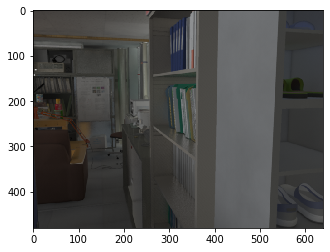

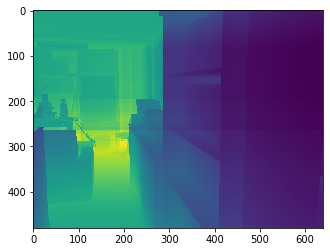

In [10]:
 #This will import the real dataset in tensor arrays once the data is available
training_DATA_LEFT = np.load('test_daylight_left.npy')
training_DATA_RIGHT = np.load('test_daylight_right.npy')
depthMaps = np.load('test_depthmap_left.npy')
depthMaps = normalize(depthMaps)
# training_DATA_LEFT = np.swapaxes(training_DATA_LEFT,1,3)
training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,3)
training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,2)

training_DATA_LEFT = torch.from_numpy(training_DATA_LEFT)
training_DATA_RIGHT = torch.from_numpy(training_DATA_RIGHT)
depthMaps = torch.from_numpy(depthMaps)

print(training_DATA_RIGHT.shape)
# reshape output
# depthMaps = depthMaps.view(-1,width*height,1,1)
plt.figure()
plt.imshow((training_DATA_RIGHT[126].detach().numpy()))
plt.show()
plt.figure()
plt.imshow(depthMaps[126].detach().numpy())
plt.show()